In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os
from scipy.signal import find_peaks

In [3]:
# t1 data

# data extracted from screenshtos of oscilloscope

taus = [0.0001,0.0010,0.0020,0.0030,0.0040,0.0060,0.0080,0.0100,0.0120,0.0150,0.0193,0.0240,0.0290,0.0340,0.0390,0.0440,0.0490,0.0540,0.0590]
peaks = [13.6,13.2,12.6,11.8,11.0,9.4,7.8,6.4,4.8,2.6,0.4,2.6,4.6,6.4,7.8,8.8,9.8,10.4,11.0]

for i in range(11,19):
    peaks[i] = -1 * peaks[i]
    
taus = np.array(taus)
peaks = np.array(peaks)

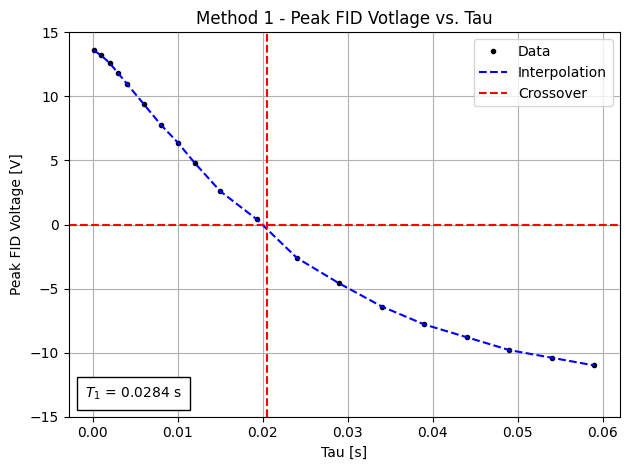

In [4]:
# t1 method one - crossover method

fig, ax = plt.subplots()
ax.plot(taus, peaks, '.k', label = "Data")
ax.plot(taus, peaks, '--b', label = "Interpolation")
ax.axhline(y=0, color = "r", linestyle = "--")
ax.axvline(x=0.0205, color = "r", linestyle = "--", label = "Crossover")
ax.grid()
ax.set_title("Method 1 - Peak FID Votlage vs. Tau")
ax.set_xlabel("Tau [s]")
ax.set_ylabel("Peak FID Voltage [V]")
ax.legend()
ax.set_ylim(-15,15)
ax.text(0.03, 0.05, f"$T_1$ = {np.round(2*np.log(2)*0.0205, 4)} s", color='black', backgroundcolor='white',
        transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', edgecolor='black', pad=6))
fig.tight_layout()

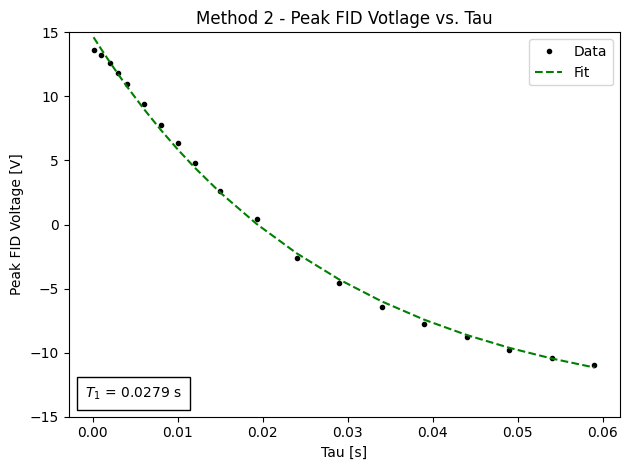

In [5]:
# t1 method two - curve fit

def Mz(t, T1, M0):
   return M0 - 2*M0*np.exp(-t/T1)
    
params, cov = curve_fit(Mz, taus, peaks, p0=[0.01,13])

fig, ax = plt.subplots()
ax.plot(taus, peaks, '.k', label = "Data")
ax.plot(taus, Mz(taus, T1=params[0], M0=params[1]),'--g' ,label = "Fit")
ax.set_title("Method 2 - Peak FID Votlage vs. Tau")
ax.set_xlabel("Tau [s]")
ax.set_ylabel("Peak FID Voltage [V]")
ax.legend()
ax.set_ylim(-15,15)
ax.text(0.03, 0.05, f"$T_1$ = {np.round(params[0], 4)} s", color='black', backgroundcolor='white',
        transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', edgecolor='black', pad=6))
fig.tight_layout()

In [6]:
data_dir = "data"
dataframes = []
names = []
taus2 = []

for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(data_dir, filename), header=None, skiprows=18)
        dataframes.append(df)
        names.append(os.path.join(data_dir, filename))
  
for i in range(0,13):
    split_temp = names[i].split(".")
    taus2.append("0." + split_temp[1])
    
taus2 = [float(tau) for tau in taus2]

df_mg_off = dataframes[13]
df_mg_on = dataframes[14]

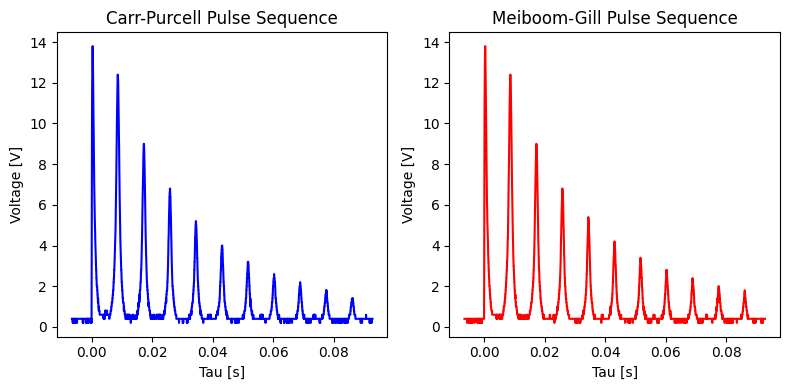

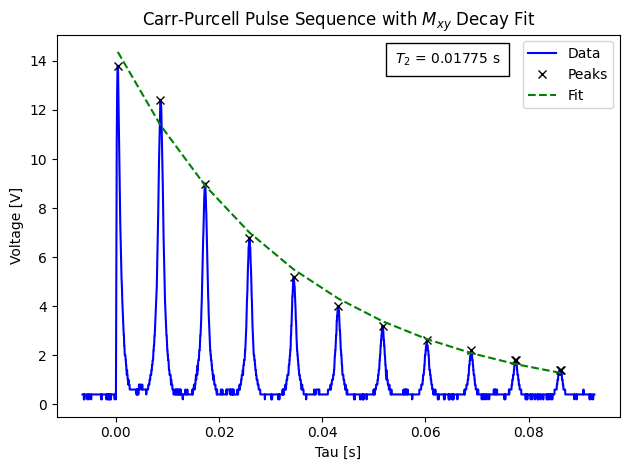

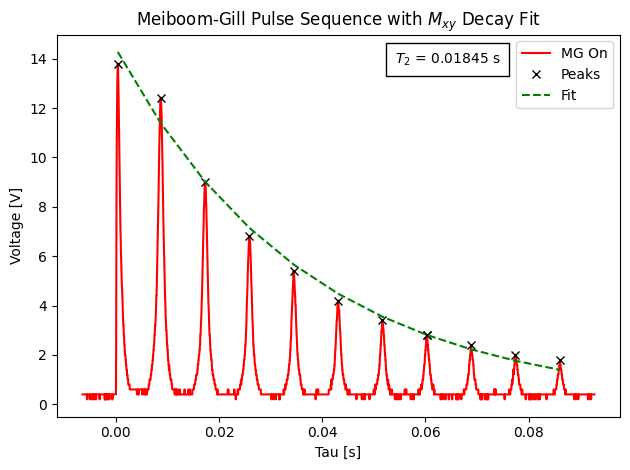

In [7]:
# T2 method one - multi-pulse sequences

def Mxy(t, M0, T2):
    return M0*np.exp(-t/T2)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize = (8,4))
ax1.plot(df_mg_off[3], df_mg_off[4], "b", label = "MG Off")
ax2.plot(df_mg_on[3], df_mg_on[4], "r", label = "MG On")
ax1.set_title("Carr-Purcell Pulse Sequence")
ax2.set_title("Meiboom-Gill Pulse Sequence")
ax1.set_xlabel("Tau [s]")
ax2.set_xlabel("Tau [s]")
ax1.set_ylabel("Voltage [V]")
ax2.set_ylabel("Voltage [V]")
fig.tight_layout()

peaks_mg_off, _ = find_peaks((df_mg_off[4]), prominence=1)
peaks_mg_on, _ = find_peaks((df_mg_on[4]), prominence=1)

voltage_mg_off = df_mg_off[4][peaks_mg_off]
voltage_mg_on = df_mg_on[4][peaks_mg_on]

peak_taus_mg_off = df_mg_off[3][peaks_mg_off]
peak_taus_mg_on = df_mg_on[3][peaks_mg_on]

params_mg_off, cov_mg_off = curve_fit(Mxy, peak_taus_mg_off, voltage_mg_off, p0 = [15, 0.01])
params_mg_on, cov_mg_on = curve_fit(Mxy, peak_taus_mg_on, voltage_mg_on, p0 = [15, 0.01])

fig, ax = plt.subplots()
ax.plot(df_mg_off[3], df_mg_off[4], "b", label = "Data")
ax.plot(peak_taus_mg_off, voltage_mg_off, 'kx', label = "Peaks")
ax.plot(peak_taus_mg_off, Mxy(peak_taus_mg_off, M0 = params_mg_off[0], T2 = params_mg_off[1]), "--g", label = "Fit")
ax.set_title("Carr-Purcell Pulse Sequence with $M_{xy}$ Decay Fit")
ax.set_ylabel("Voltage [V]")
ax.set_xlabel("Tau [s]")
ax.legend()
ax.text(0.6, 0.925, f"$T_2$ = {np.round(params_mg_off[1], 4)/2} s", color='black', backgroundcolor='white',
        transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', edgecolor='black', pad=6))
fig.tight_layout()

fig, ax = plt.subplots()
ax.plot(df_mg_on[3], df_mg_on[4], "r", label = "MG On")
ax.plot(peak_taus_mg_on, voltage_mg_on, "kx", label = "Peaks")
ax.plot(peak_taus_mg_on, Mxy(peak_taus_mg_on, M0 = params_mg_on[0], T2 = params_mg_on[1]), "--g" ,label = "Fit")
ax.set_title("Meiboom-Gill Pulse Sequence with $M_{xy}$ Decay Fit")
ax.set_ylabel("Voltage [V]")
ax.set_xlabel("Tau [s]")
ax.legend()
ax.text(0.6, 0.925, f"$T_2$ = {np.round(params_mg_on[1], 4)/2} s", color='black', backgroundcolor='white',
        transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', edgecolor='black', pad=6))
fig.tight_layout()

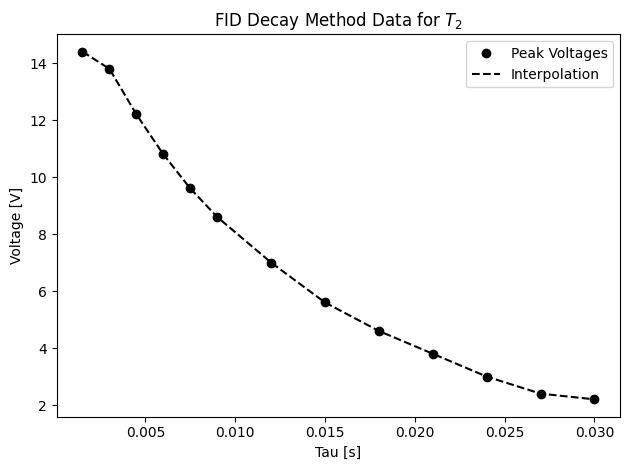

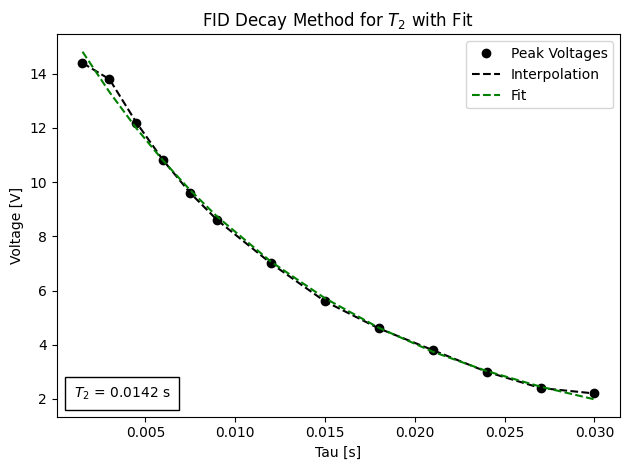

In [10]:
# t2 method 2 - fid decay 

max_voltages = []
for i, df in enumerate(dataframes):
    if i <= 12:
        peaks, _ = find_peaks(df[4], prominence = 1.5)
        max_voltages.append(df[4][peaks[1]])
    else:
        None

fig, ax = plt.subplots()   
ax.plot(taus2, max_voltages, 'ok', label = "Peak Voltages")
ax.plot(taus2, max_voltages, "--k", label = "Interpolation")
ax.legend()
ax.set_ylabel("Voltage [V]")
ax.set_xlabel("Tau [s]")
ax.set_title("FID Decay Method Data for $T_2$")
ax.legend()
fig.tight_layout()

taus2 = np.array(taus2)
params_fid, cov_fid = curve_fit(Mxy, taus2, max_voltages, p0 = [15, 0.01])

fig, ax = plt.subplots()
ax.plot(taus2, max_voltages, 'ok', label = "Peak Voltages")
ax.plot(taus2, max_voltages, "--k", label = "Interpolation")
ax.plot(taus2, Mxy(taus2, M0 = params_fid[0], T2 = params_fid[1]), "--g", label = "Fit")
ax.legend()
ax.set_ylabel("Voltage [V]")
ax.set_xlabel("Tau [s]")
ax.set_title("FID Decay Method for $T_2$ with Fit")
ax.legend()
ax.text(0.03, 0.05, f"$T_2$ = {np.round(params_fid[1],4)} s", color='black', backgroundcolor='white',
        transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', edgecolor='black', pad=6))
fig.tight_layout()